In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os


from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Firstly, we need to read in all training data.

In [27]:
train_dataset = 'dataset/training/' 
test_dataset = 'dataset/testing/'

We now need to preprocess images within each dataset and label them according to their classification.

In [28]:
def preprocess_image(img_path):
    # read in the image
    img = cv2.imread(img_path)

    # convert image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # normalize the data
    img = img / 255

    # resize the image for uniformity
    img = cv2.resize(img, (256, 256))

    return img

In [29]:
label_encoder = LabelEncoder()

def load_data(dataset_path):
    x_data = [] # images
    y_data = [] # labels

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)

        # check if the path is a directory and skip if not
        if not os.path.isdir(folder_path):
            continue  
        
        for file in os.listdir(folder_path):
            # find path of the image
            file_path = os.path.join(folder_path, file)

            # preprocess the image
            img = preprocess_image(file_path)

            # append the new image to the x array
            x_data.append(img)

            # append the label to the y array
            y_data.append(folder)

    # encode the labels
    y_data = label_encoder.fit_transform(y_data)

    x_data = np.array(x_data)
    y_data = np.array(y_data)

    x_data, y_data = shuffle(x_data, y_data, random_state=8)
    
    return x_data, y_data


In [30]:
x_train, y_train = load_data(train_dataset)
x_test, y_test = load_data(test_dataset)

Now with our data we can choose and create our model.

In [31]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(256, 256)),
    tf.keras.layers.Dense(128, activation='softmax')
])

In [32]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy() , 
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In order to test this model we need to get our training data and perform the same preprocessing on the data.

In [34]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
90/90 [==============================] - 2s 15ms/step - loss: 1.7082 - accuracy: 0.5470 - val_loss: 4.1692 - val_accuracy: 0.4619
Epoch 2/10
90/90 [==============================] - 1s 12ms/step - loss: 0.7772 - accuracy: 0.7223 - val_loss: 4.5911 - val_accuracy: 0.5584
Epoch 3/10
90/90 [==============================] - 1s 13ms/step - loss: 0.6536 - accuracy: 0.7662 - val_loss: 5.2337 - val_accuracy: 0.4239
Epoch 4/10
90/90 [==============================] - 1s 14ms/step - loss: 0.7296 - accuracy: 0.7585 - val_loss: 5.4979 - val_accuracy: 0.5558
Epoch 5/10
90/90 [==============================] - 1s 12ms/step - loss: 0.6208 - accuracy: 0.7892 - val_loss: 6.1685 - val_accuracy: 0.5736
Epoch 6/10
90/90 [==============================] - 1s 13ms/step - loss: 0.3680 - accuracy: 0.8659 - val_loss: 6.4257 - val_accuracy: 0.6041
Epoch 7/10
90/90 [==============================] - 1s 12ms/step - loss: 0.3331 - accuracy: 0.8815 - val_loss: 5.7494 - val_accuracy: 0.6599
Epoch 8/10
90

With this working model, we can evaluate the model and make our observations via the following.

In [55]:
def plot_metrics(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend(['Accuracy', 'Loss'])
    plt.title('Neural Network Performance')
    plt.show()

In [53]:
def plot_confusion_matrix(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    display.plot()

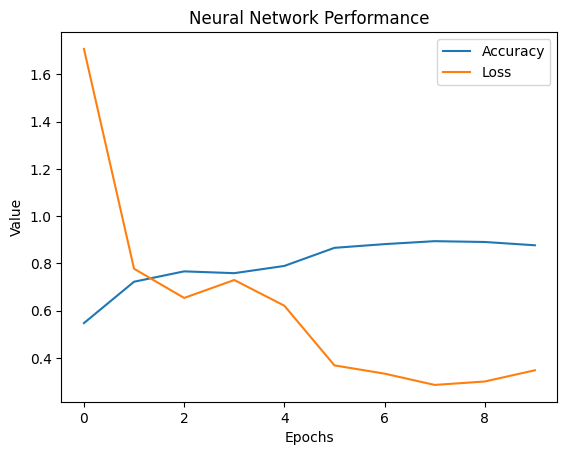

In [57]:
plot_metrics(history)

13/13 [==============================] - 0s 3ms/step


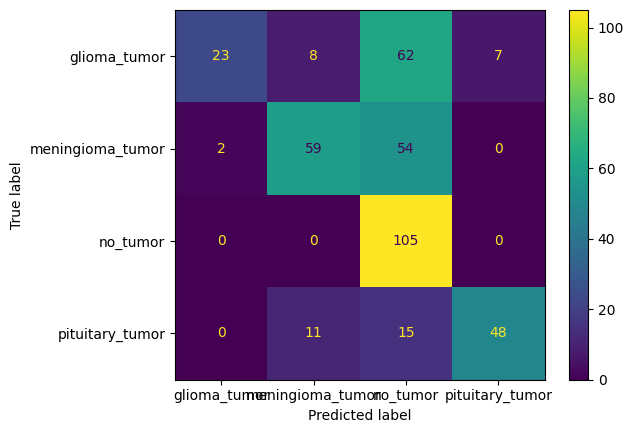

In [54]:
plot_confusion_matrix(model, x_test, y_test)

Finally, we can use our model to make predictions on images outside of our dataset through the following.

In [70]:
def make_prediction(image_path):
    # preprocess the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255
    img = cv2.resize(img, (256, 256))

    # reshape the image to match the input shape of the model
    img = np.reshape(img, (1, 256, 256))

    # make the prediction
    prediction = model.predict(img)
    prediction = np.argmax(prediction, axis=1)[0]
    prediction = label_encoder.inverse_transform([prediction])[0]

    print(f'The predicted label is: {prediction}')

In [71]:
make_prediction('dataset/meningioma.png')

1/1 [==============================] - 0s 12ms/step
The predicted label is: meningioma_tumor
